**[Official documentation for OBP](https://zr-obp.readthedocs.io/en/latest/)**

## Quick Reference:

**OBP: Open Bandit Pipeline** - this software library

**OBD: Open Bandit Dataset** - the dataset supplied with it

**OPE: off-policy evaluation** - the process of determining how a policy _other than the one that was really run_ woudl have performed

## Dataset Loader


In [1]:
from pathlib import Path
from obp.dataset import OpenBanditDataset

DATASET = "../data/obd"
# DATASET = "../data/obd_toy"

dataset = OpenBanditDataset(
    data_path=Path(DATASET),
    campaign="all",
    behavior_policy="random"
)

feedback = dataset.obtain_batch_bandit_feedback()

/Users/johnnyma/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Adding in random 'segments' so the simulator can run segment-based policies 

In [2]:
import numpy as np
import pandas as pd
from pandas import DataFrame

feedback['segment'] = np.random.randint(10, size = feedback['action'].shape)

## Policy and Simulator

Testing out self-implemented `ExploreThenCommit` and comparing with OBP's `Epsilon Greedy`

In [3]:
from obp.policy import EpsilonGreedy, BaseContextFreePolicy

from sd_bandits.obp_extensions.policy import ExploreThenCommit, SegmentPolicy, KLUpperConfidenceBound
from sd_bandits.obp_extensions.simulator import run_bandit_simulation

etc = ExploreThenCommit(
    n_actions=dataset.n_actions,
    len_list = dataset.len_list,
    batch_size=1, # update parameters after every round
    random_state=0,
    min_n = 30
)

eps_greedy = EpsilonGreedy(
    n_actions=dataset.n_actions,
    len_list = dataset.len_list,
    batch_size=1, # update parameters after every round
    random_state=0,
    epsilon=0.2
)

etc_base = ExploreThenCommit(
    n_actions=dataset.n_actions,
    len_list = dataset.len_list,
    batch_size=1, # update parameters after every round
    random_state=0,
    min_n = 5
)
seg_etc = SegmentPolicy(etc_base, n_segments=10)

kl_ucb = KLUpperConfidenceBound(
    n_actions=dataset.n_actions,
    len_list = dataset.len_list,
    batch_size=1000,
    random_state=0,
)
kl_ucb_seg = SegmentPolicy(kl_ucb, n_segments=10)

In [4]:
seg_etc_actions = run_bandit_simulation(bandit_feedback=feedback, policy = seg_etc)

etc_actions = run_bandit_simulation(bandit_feedback=feedback, policy=etc)

eps_actions = run_bandit_simulation(bandit_feedback=feedback, policy=eps_greedy)

kl_ucb_actions = run_bandit_simulation(bandit_feedback=feedback, policy=kl_ucb)

100%|██████████| 1374327/1374327 [00:17<00:00, 80239.48it/s]


How often each action was shown

In [5]:
print('Explore-Then-Commit')
print(etc.action_counts)
print()
print('Epsilon-Greedy')
print(eps_greedy.action_counts)
print()
print('Segmented ETC')
print(seg_etc.action_counts)
print()
print('KL_UCB')
print(kl_ucb.action_counts)

Explore-Then-Commit
[  30   30   30   30   30   30   30   30   30 1259   30   30   30   30
   30   30   30   30  629   30   30   30   30   30   30   30  315   30
   30   30   30   30   30   30   30   30   30  315   30  315   30   30
   30   30   30 3906   30   30   30   30   30   30   30   30   30   30
   30   30   30   30   30   30   30   30   30   30   30   30   30   30
   30   30   30   30  315  630   30   30   30   30]

Epsilon-Greedy
[1506   60  572   46   49   38   43   67   41   59   41   38   54   46
   42   47   45   41   54   48   38  271   57   45   56   44   35   33
   47   45   49   52   34   44 1891   53   31   51   42 1192   51   56
   47  571   44   39   46   45   34  810   45   42   42   45   42   42
   45   66   39   46   49   40   39   39   43   52   63  147   49   46
   53   47   42   46   38  573   43   41  987 2188]

Segmented ETC
[101.  87. 105. 102. 101.  91. 223. 107. 505. 171. 100. 504.  99. 105.
  92.  86. 556.  98. 523. 554.  95. 103. 398.  96.  88.  82. 105

Relative 'reward' of each action

In [6]:
print('Explore-Then-Commit')
print(etc.reward_counts)
print()
print('Epsilon-Greedy')
print(eps_greedy.reward_counts)
print()
print('Segmented ETC')
print(seg_etc.reward_counts)
print()
print('KL UCB')
print(kl_ucb.reward_counts)

Explore-Then-Commit
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.00317712 0.         0.
 0.         0.         0.         0.         0.         0.
 0.00317965 0.         0.         0.         0.         0.
 0.         0.         0.0031746  0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.0031746  0.         0.0031746  0.         0.
 0.         0.         0.         0.00486431 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.0031746  0.0031746  0.         0.
 0.         0.        ]

Epsilon-Greedy
[0.00464807 0.         0.00174825 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        

How often each action was clicked on

In [7]:
print('Explore-Then-Commit')
print(etc.reward_counts * etc.action_counts)
print()
print('Epsilon-Greedy')
print(eps_greedy.reward_counts * eps_greedy.action_counts)
print()
print('Segmented ETC')
print(seg_etc.reward_counts * seg_etc.action_counts)
print()
print('KL UCB')
print(kl_ucb.reward_counts*kl_ucb.action_counts)

Explore-Then-Commit
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  4.  0.  0.  0.  0.  0.  0.  0.  0.
  2.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  1.  0.  1.  0.  0.  0.  0.  0. 19.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  1.  2.  0.  0.  0.  0.]

Epsilon-Greedy
[ 7.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 11.  0.
  0.  0.  0. 19.  0.  0.  0.  1.  0.  0.  0.  0.  0.  2.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.
  0.  0.  0.  1.  0.  0.  3. 18.]

Segmented ETC
[0. 0. 0. 0. 0. 0. 1. 0. 2. 1. 0. 3. 0. 0. 0. 0. 3. 0. 3. 4. 0. 0. 2. 0.
 0. 0. 0. 0. 0. 0. 0. 2. 0. 1. 0. 0. 0. 0. 0. 3. 0. 1. 3. 4. 0. 7. 0. 1.
 5. 2. 0. 1. 0. 5. 0. 2. 2. 0. 0. 0. 0. 3. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0.]

KL UCB
[0. 3. 0. 2. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1

## Off-Policy Evaluation

Some off-polict evaluation methods require a base regression model (like the Direct Method and all methods that use the Direct Method). So, we import LinearRegression in this case, although smarter ones can be used

OBP allows us to measure multiple OPEs at once using the `OffPolicyEvaluation` module

In [8]:
from pathlib import Path
from sklearn.linear_model import LinearRegression
# import open bandit pipeline (obp)
from obp.ope import (
    OffPolicyEvaluation, 
    RegressionModel,
    DirectMethod,
    InverseProbabilityWeighting,
    DoublyRobust,
    DoublyRobustWithShrinkage,
    SelfNormalizedDoublyRobust
)

regression_model = RegressionModel(
    n_actions=dataset.n_actions,
    len_list=dataset.len_list,
    action_context=dataset.action_context,
    base_model=LinearRegression(),
)

estimated_rewards_by_reg_model = regression_model.fit_predict(
    context=feedback["context"],
    action=feedback["action"],
    reward=feedback["reward"],
    position=feedback["position"],
    pscore=feedback["pscore"],
    n_folds=3, # use 3-fold cross-fitting,
    random_state=12345,
)


Explore then commit analysis:

In [9]:
ope = OffPolicyEvaluation(
    bandit_feedback=feedback,
    ope_estimators=[InverseProbabilityWeighting(), DirectMethod(), DoublyRobust(),
                    DoublyRobustWithShrinkage(lambda_ = 1e3), SelfNormalizedDoublyRobust()]
)

# `summarize_off_policy_estimates` returns pandas dataframes including the OPE results
estimated_policy_value, estimated_interval = ope.summarize_off_policy_estimates(
    action_dist=etc_actions, 
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
    random_state=12345,
)

In [14]:
# ground-truth policy value of the random policy
# , which is the empirical mean of the factual (observed) rewards (on-policy estimation)
ground_truth = feedback['reward'].mean()

# calculate estimated policy value of the evaluation policy (the BernoulliTS policy)
# relative to the ground-truth policy value of the behavior policy (the Random policy here)
estimated_policy_value['relative_estimated_policy_value'] =\
        estimated_policy_value.estimated_policy_value / ground_truth

In [15]:
estimated_policy_value

,estimated_policy_value,relative_estimated_policy_value
ipw,0.001805,0.520134
dm,0.003456,0.996156
dr,0.003318,0.956286
dr-os,0.003437,0.990768
sndr,0.003215,0.926577


In [16]:
estimated_interval

,mean,95.0% CI (lower),95.0% CI (upper)
ipw,0.001853,0.001106,0.002650
dm,0.003456,0.003454,0.003457
dr,0.003366,0.002645,0.004156
dr-os,0.003444,0.003347,0.003550
sndr,0.003299,0.002040,0.004678


Visualization for Epsilon-Greedy

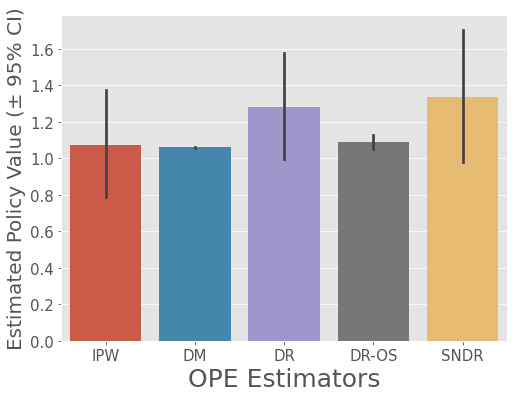

In [17]:
ope.visualize_off_policy_estimates(
    action_dist=eps_actions,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
    is_relative=True,
    random_state=12345,
    fig_dir = Path('../figures'),
    fig_name = 'eps_greedy_OPE_prelim_results.png'
)

Visualization for ETC

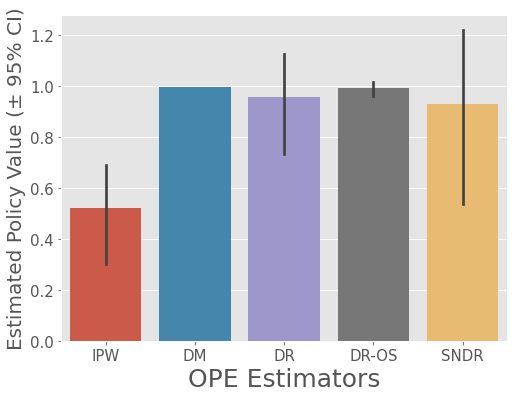

In [18]:
ope.visualize_off_policy_estimates(
    action_dist=etc_actions,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
    is_relative=True,
    random_state=12345,
    fig_dir = Path('../figures'),
    fig_name = 'etc_OPE_prelim_results.png'
)

Segmented etc

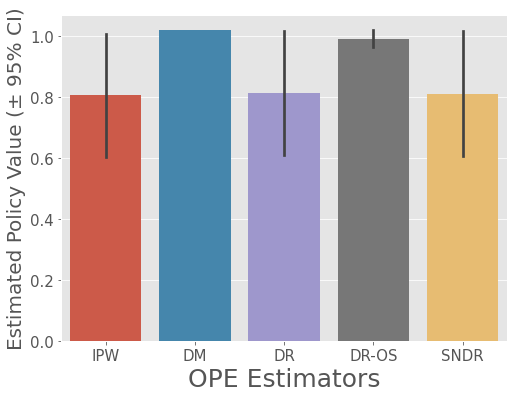

In [25]:
ope.visualize_off_policy_estimates(
    action_dist=seg_etc_actions,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
    is_relative=True,
    random_state=12345,
    fig_dir = Path('../figures'),
    fig_name = 'seg_etc_OPE_prelim_results.png'
)

KL upper confidence bound

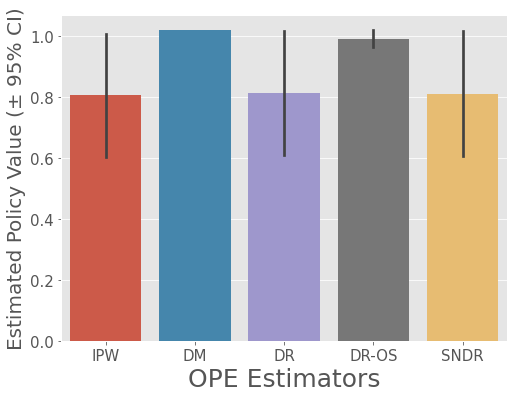

In [26]:
ope.visualize_off_policy_estimates(
    action_dist=seg_etc_actions,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
    is_relative=True,
    random_state=12345,
    fig_dir = Path('../figures'),
    fig_name = 'seg_etc_OPE_prelim_results.png'
)

In [25]:
def get_estimated_round_rewards(
    action_dist,
    estimated_rewards_by_reg_model,
    is_relative,
    ope):

    estimated_round_rewards_dict = dict()
    estimator_inputs = ope._create_estimator_inputs(
                action_dist=action_dist,
                estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
            )
    for estimator_name, estimator in ope.ope_estimators_.items():
                estimated_round_rewards_dict[
                    estimator_name
                ] = estimator._estimate_round_rewards(**estimator_inputs)
    estimated_round_rewards_df = DataFrame(estimated_round_rewards_dict)
    estimated_round_rewards_df.rename(
                columns={key: key.upper() for key in estimated_round_rewards_dict.keys()},
                inplace=True,
            )
    
    if is_relative:
        estimated_round_rewards_df /= ope.bandit_feedback["reward"].mean()

    return estimated_round_rewards_df

In [26]:
# run for Epsilon Greedy
eps_data = get_estimated_round_rewards(action_dist = eps_actions,
                      estimated_rewards_by_reg_model= estimated_rewards_by_reg_model,
                      is_relative = True,
                      ope = ope)

In [35]:
def visualize_policy_value_by_round(estimated_round_rewards,
                                   n_rounds,
                                   n_bootstrap_samples,
                                   random_state,
                                   one_graph,
                                   fig_dir,
                                   fig_name):
    
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    # using linear space, can switch to log later. 
    data = estimated_round_rewards
    n_rounds = np.linspace(1000, len(data), n_rounds, dtype = 'int') 
    alpha = 0.05 # CI bootstrap percentile
    
    means_df = DataFrame()
    lci_df = DataFrame()
    uci_df = DataFrame()
    
    # filling boot strapped means and CI
    for n_round in n_rounds:
        boot_ci = sns.utils.ci(sns.algorithms.bootstrap(data[:n_round], func=np.mean, n_boot=n_bootstrap_samples, seed=random_state, axis = 0), axis = 0)
        means_df = means_df.append(data[:n_round].mean(), ignore_index=True)
        lci_df = lci_df.append(DataFrame(boot_ci[0]).T)
        uci_df = uci_df.append(DataFrame(boot_ci[1]).T)
    
    # renaming columns and indices
    means_df.index, lci_df.index, uci_df.index = [list(n_rounds)] * 3
    means_df.index.name, lci_df.index.name, uci_df.index.name = ['n_rounds']*3
    lci_df.columns, uci_df.columns = [data.columns]*2
    
    plt.clf()
    if one_graph:
        for ope in means_df.columns:
            plt.plot(means_df[ope], label = ope)
            plt.errorbar(means_df.index, means_df[ope], 
                         yerr = np.array([means_df[ope]-lci_df[ope], uci_df[ope]-means_df[ope]]),
                         label=ope)
            plt.legend(loc='lower right')
            plt.xlabel('n_rounds')
            plt.ylabel(f"Estimated Policy Value (± {np.int(100*(1 - alpha))}% CI)")
            
            # saving
            if fig_dir:
                plt.savefig(str(fig_dir / fig_name))
    else:
        ind = 0
        for ope in means_df.columns:
            plt.figure(ind)
            plt.plot(means_df[ope], label = ope)
            plt.errorbar(means_df.index, means_df[ope], 
                         yerr = np.array([means_df[ope]-lci_df[ope], uci_df[ope]-means_df[ope]]),
                        label = ope)
            plt.legend(loc='lower right')
            plt.xlabel('n_rounds')
            plt.ylabel(f"Estimated Policy Value (± {np.int(100*(1 - alpha))}% CI)")
            plt.title('Policy Value by Rounds: ' + ope)
            ind += 1
            
            if fig_dir:
                plt.savefig(str(fig_dir / (ope + fig_name)))
            
       

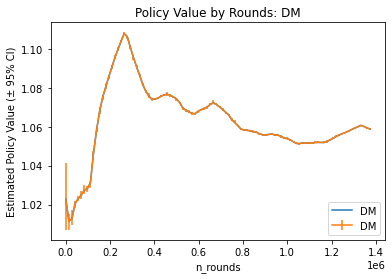

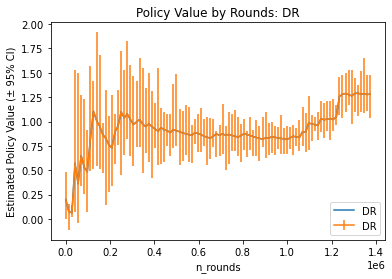

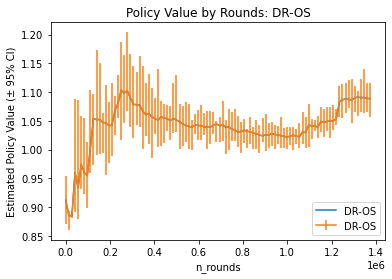

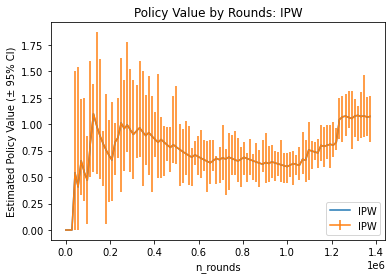

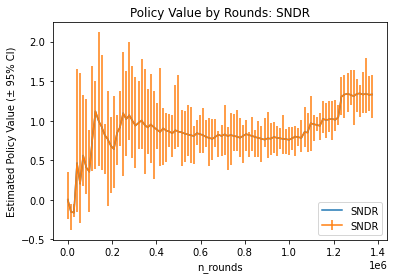

In [36]:
visualize_policy_value_by_round(eps_data,
                               n_rounds = 100,
                               n_bootstrap_samples = 10,
                               random_state = 12345,
                               one_graph = False,
                               fig_dir = Path('../figures'),
                               fig_name = 'est_OPE_nrounds_results.png'
                               )